## **Предобработка данных**

# **Загрузка данных**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import shapiro
from scipy import stats
from scipy.stats import pearsonr
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

In [ ]:
# монтируем связь с google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Загружаем данные из Excel-файла
data_df = pd.read_excel('/content/drive/MyDrive/Данные_для_курсовои_Классическое_МО.xlsx')

# Выводим первые 5 строк DataFrame
print(data_df.head())

   Unnamed: 0    IC50, mM    CC50, mM         SI  MaxAbsEStateIndex  \
0           0    6.239374  175.482382  28.125000           5.094096   
1           1    0.771831    5.402819   7.000000           3.961417   
2           2  223.808778  161.142320   0.720000           2.627117   
3           3    1.705624  107.855654  63.235294           5.097360   
4           4  107.131532  139.270991   1.300000           5.150510   

   MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex       qed        SPS  \
0        5.094096           0.387225        0.387225  0.417362  42.928571   
1        3.961417           0.533868        0.533868  0.462473  45.214286   
2        2.627117           0.543231        0.543231  0.260923  42.187500   
3        5.097360           0.390603        0.390603  0.377846  41.862069   
4        5.150510           0.270476        0.270476  0.429038  36.514286   

   ...  fr_sulfide  fr_sulfonamd  fr_sulfone  fr_term_acetylene  fr_tetrazole  \
0  ...           0           

# **Обработка пропущенных значений**

In [ ]:
# Подсчет пропусков до обработки
missing_before = data_df.isnull().sum().sum()
print(f"Missing values before: {missing_before}")

# Заполнение пропусков медианой для числовых признаков
numeric_cols = data_df.select_dtypes(include=[np.number]).columns
data_df[numeric_cols] = data_df[numeric_cols].fillna(data_df[numeric_cols].median())

Missing values before: 0


In [ ]:
# Проверим, что наши показатели были преобразованы
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,1001.0,500.000000,289.108111,0.000000,250.000000,500.000000,750.000000,1000.000000
"IC50, mM",1001.0,222.805156,402.169734,0.003517,12.515396,46.585183,224.975928,4128.529377
"CC50, mM",1001.0,589.110728,642.867508,0.700808,99.999036,411.039342,894.089176,4538.976189
SI,1001.0,72.508823,684.482739,0.011489,1.433333,3.846154,16.566667,15620.600000
MaxAbsEStateIndex,1001.0,10.831637,3.307505,2.321942,9.252350,12.179236,13.167843,15.933463
...,...,...,...,...,...,...,...,...
fr_thiazole,1001.0,0.051948,0.222033,0.000000,0.000000,0.000000,0.000000,1.000000
fr_thiocyan,1001.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
fr_thiophene,1001.0,0.069930,0.255157,0.000000,0.000000,0.000000,0.000000,1.000000
fr_unbrch_alkane,1001.0,0.204795,1.215326,0.000000,0.000000,0.000000,0.000000,20.000000


# **Исследование данных на корреляциию**

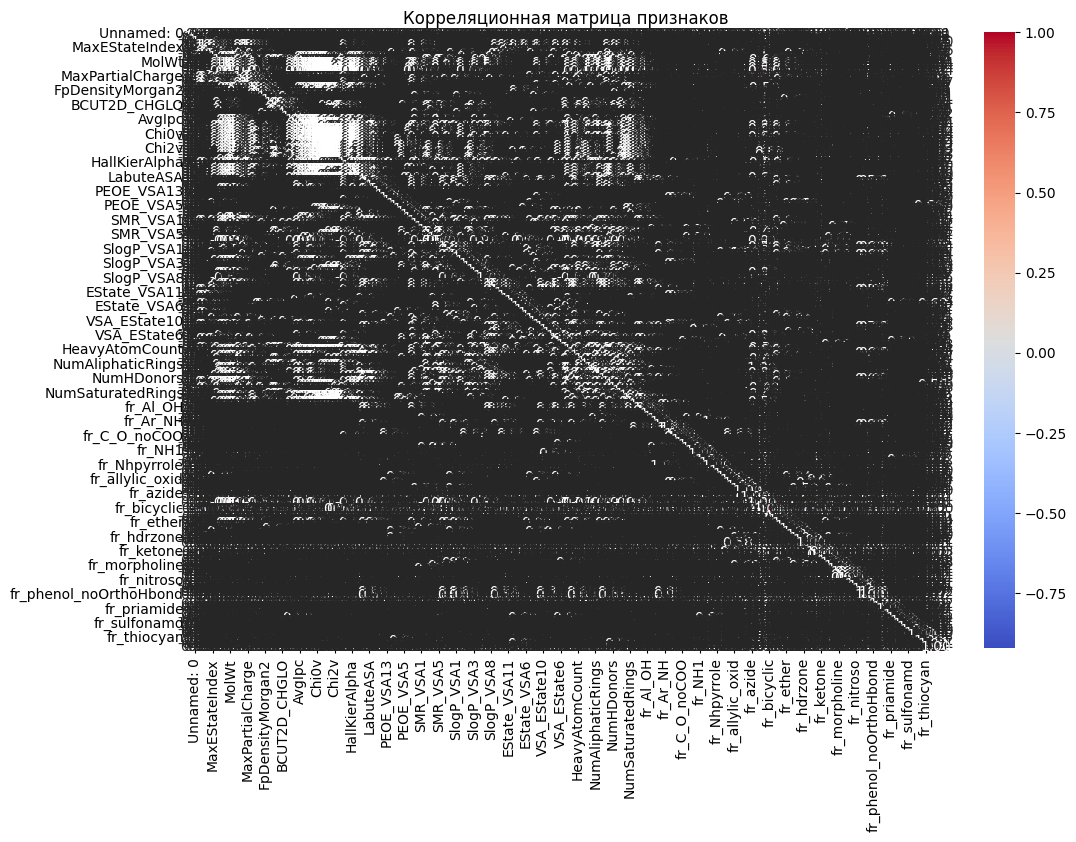

In [ ]:
# Рассчитываем корреляционную матрицу
correlation_matrix = data_df.corr()

# Визуализация корреляционной матрицы
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Корреляционная матрица признаков")
plt.show()

   Unnamed: 0    IC50, mM    CC50, mM         SI  MinAbsEStateIndex  \
0           0    6.239374  175.482382  28.125000           0.387225   
1           1    0.771831    5.402819   7.000000           0.533868   
2           2  223.808778  161.142320   0.720000           0.543231   
3           3    1.705624  107.855654  63.235294           0.390603   
4           4  107.131532  139.270991   1.300000           0.270476   

   MinEStateIndex       qed        SPS  NumRadicalElectrons  BCUT2D_MWHI  ...  \
0        0.387225  0.417362  42.928571                    0    14.822266  ...   
1        0.533868  0.462473  45.214286                    0    14.975110  ...   
2        0.543231  0.260923  42.187500                    0    15.353938  ...   
3        0.390603  0.377846  41.862069                    0    14.821216  ...   
4        0.270476  0.429038  36.514286                    0    14.831112  ...   

   fr_sulfide  fr_sulfonamd  fr_sulfone  fr_term_acetylene  fr_tetrazole  \
0         

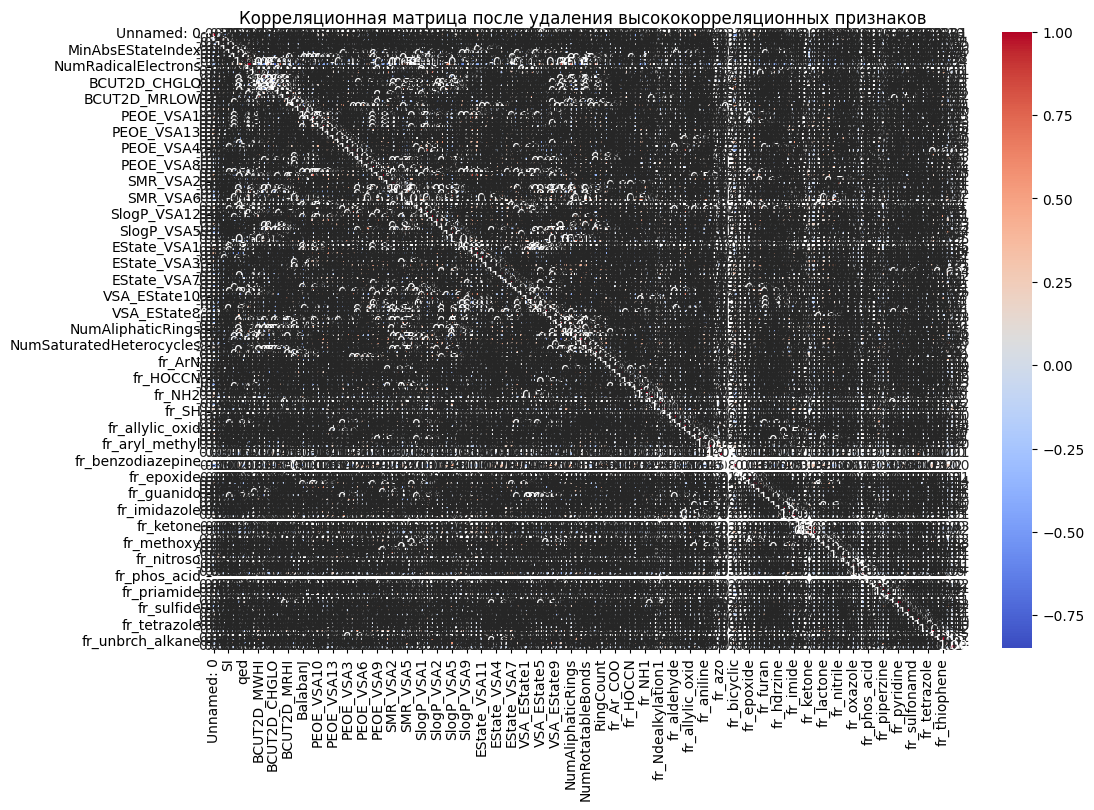

In [ ]:
# Задаем порог для корреляции
threshold = 0.9

# Список для хранения признаков, которые нужно удалить
to_drop = []

# Перебираем пары признаков
for col in correlation_matrix.columns:
    for row in correlation_matrix.index:
        # Проверяем, является ли корреляция выше порога и не равна ли она 1
        if col != row and abs(correlation_matrix[col][row]) > threshold:
            to_drop.append(row)

# Удаляем дубликаты и оставляем только уникальные названия признаков
to_drop = list(set(to_drop))

# Удаляем высококоррелированные признаки из DataFrame
data_df_cleaned = data_df.drop(columns=to_drop)

# Выводим очищенный DataFrame
print(data_df_cleaned.head())

# Для визуализации скорректированной корреляционной матрицы
correlation_matrix_cleaned = data_df_cleaned.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_cleaned, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Корреляционная матрица после удаления высококорреляционных признаков")
plt.show()

# **Обработка выбросов**

In [ ]:
# Функция для удаления выбросов на основе IQR
def remove_outliers_iqr(df):
    # Копируем DataFrame для избежания изменения оригинала
    df_no_outliers = df.copy()

    for col in df_no_outliers.select_dtypes(include=[float, int]).columns:
        Q1 = df_no_outliers[col].quantile(0.25)
        Q3 = df_no_outliers[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Удаляем выбросы
        df_no_outliers = df_no_outliers[(df_no_outliers[col] >= lower_bound) & (df_no_outliers[col] <= upper_bound)]

    return df_no_outliers

# Применяем функцию к очищенному DataFrame
data_df_final = remove_outliers_iqr(data_df_cleaned)

# Выводим результат
print(data_df_final.head())

     Unnamed: 0   IC50, mM    CC50, mM         SI  MinAbsEStateIndex  \
19           19  64.130535  283.628863   4.422680           0.300347   
754         754  47.000410  199.994711   4.255170           0.300347   
755         755  60.996734    0.700808   0.011489           0.300347   
756         756  11.001362    0.700808   0.063702           0.300347   
757         757   3.398257   70.001455  20.599222           0.300347   

     MinEStateIndex       qed        SPS  NumRadicalElectrons  BCUT2D_MWHI  \
19         0.300347  0.562066  60.272727                    0    14.788664   
754        0.300347  0.562066  60.272727                    0    14.788664   
755        0.300347  0.562066  60.272727                    0    14.788664   
756        0.300347  0.562066  60.272727                    0    14.788664   
757        0.300347  0.562066  60.272727                    0    14.788664   

     ...  fr_sulfide  fr_sulfonamd  fr_sulfone  fr_term_acetylene  \
19   ...           0         

# **Подготовка данных**

In [ ]:
# Целевая переменная
y = data_df_final['IC50, mM']  # Логарифмическое преобразование

# Признаки
X = data_df_final.drop(['IC50, mM', 'CC50, mM', 'SI'], axis=1)

# Удаление константных столбцов
constant_columns = [col for col in X.columns if X[col].nunique() == 1]
X = X.drop(constant_columns, axis=1)

# Заполнение пропущенных значений
X = X.fillna(X.median())

# Разделение на train и test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
import warnings

# **Базовые модели регрессии**

In [ ]:
# Список моделей для сравнения
models = [
    ('Linear Regression', LinearRegression()),
    ('Ridge Regression', Ridge(random_state=42)),
    ('Lasso Regression', Lasso(random_state=42)),
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('Gradient Boosting', GradientBoostingRegressor(random_state=42)),
    ('XGBoost', XGBRegressor(random_state=42))
]

In [21]:
# Оценка моделей с помощью кросс-валидации
results = []
names = []
for name, model in models:
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-cv_scores)
    results.append(rmse_scores)
    names.append(name)
    print(f"{name}: Средний RMSE = {rmse_scores.mean():.4f}, STD = {rmse_scores.std():.4f}")

Linear Regression: Средний RMSE = 24.2561, STD = 8.1674
Ridge Regression: Средний RMSE = 25.9110, STD = 5.9735
Lasso Regression: Средний RMSE = 26.5908, STD = 6.0820
Random Forest: Средний RMSE = 21.7968, STD = 8.6239
Gradient Boosting: Средний RMSE = 20.0423, STD = 8.7089
XGBoost: Средний RMSE = 25.5866, STD = 13.1237


**Заключение**

Заключение

Из представленных моделей наилучшие результаты показывает Gradient Boosting, так как у него самый низкий средний RMSE (20.0423). Это означает, что эта модель делает прогнозы с наименьшей ошибкой по сравнению с другими моделями, включая Linear Regression, Ridge Regression, Lasso Regression, Random Forest и XGBoost.